# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation**

In [2]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.9 MB/s eta 0:00:00


#### **Import Necessary Libraries**

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import keras_tuner as kt
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras_tuner import HyperModel
from sklearn.model_selection import ParameterGrid

### **1.1 Data Aggregation**

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1**
Create the function to join DataFrames and use it to combine the four datasets.

In [7]:
from google.colab import files
uploaded = files.upload()

Saving AMZN_stocks_data.csv to AMZN_stocks_data.csv
Saving GOOGL_stocks_data.csv to GOOGL_stocks_data.csv
Saving IBM_stocks_data.csv to IBM_stocks_data.csv
Saving MSFT_stocks_data.csv to MSFT_stocks_data.csv


In [8]:
# Define a function to load data and aggregate them

def load_and_aggregate_stock_data(file_list):

    combined_df = pd.DataFrame()

    for file in file_list:
        # Extract stock name from file name (before '_')
        stock_name = os.path.basename(file).split('_')[0]

        # Load the data
        df = pd.read_csv(file)

        # Add a new column for stock name
        df['Stock'] = stock_name

        # Drop 'Name' column if it exists
        if 'Name' in df.columns:
            df.drop(columns=['Name'], inplace=True)

        # Append to combined DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    return combined_df

In [9]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

files = ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'IBM_stocks_data.csv', 'MSFT_stocks_data.csv']
combined_stock_data = load_and_aggregate_stock_data(files)
print(combined_stock_data.head())

         Date   Open   High    Low  Close   Volume Stock
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN


In [10]:
# View specifics of the data

combined_stock_data.describe()

,Open,High,Low,Close,Volume
count,12076.000000,12077.000000,12076.000000,12077.000000,1.207700e+04
mean,227.387118,229.422254,225.203189,227.380960,1.671763e+07
std,236.938260,238.568485,234.981015,236.851101,2.570572e+07
min,15.200000,15.620000,14.870000,15.150000,2.542560e+05
25%,54.930000,55.660000,54.425000,55.210000,3.124704e+06
50%,158.795000,160.410000,157.355000,158.880000,5.445269e+06
75%,281.405000,284.500000,278.610000,281.510000,1.802087e+07
max,1204.880000,1213.410000,1191.150000,1195.830000,5.910786e+08


In [11]:
#View Shape of the data
print('Shape of Data:',combined_stock_data.shape)
print(combined_stock_data.columns.tolist())
print(combined_stock_data.info())


Shape of Data: (12077, 7)
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Stock']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Stock   12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB
None


#### **1.1.2**
Identify and handle any missing values.

In [12]:
# Handle Missing Values
combined_stock_data.isnull().sum()

,0
Date,0
Open,1
High,0
Low,1
Close,0
Volume,0
Stock,0


In [13]:
#dropping the missing values
cleaned_data = combined_stock_data.dropna()
print("\nData After dropping the null values:\n", cleaned_data.isnull().sum())


Data After dropping the null values:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Stock     0
dtype: int64


### **1.2 Analysis and Visualisation**

#### **1.2.1**
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

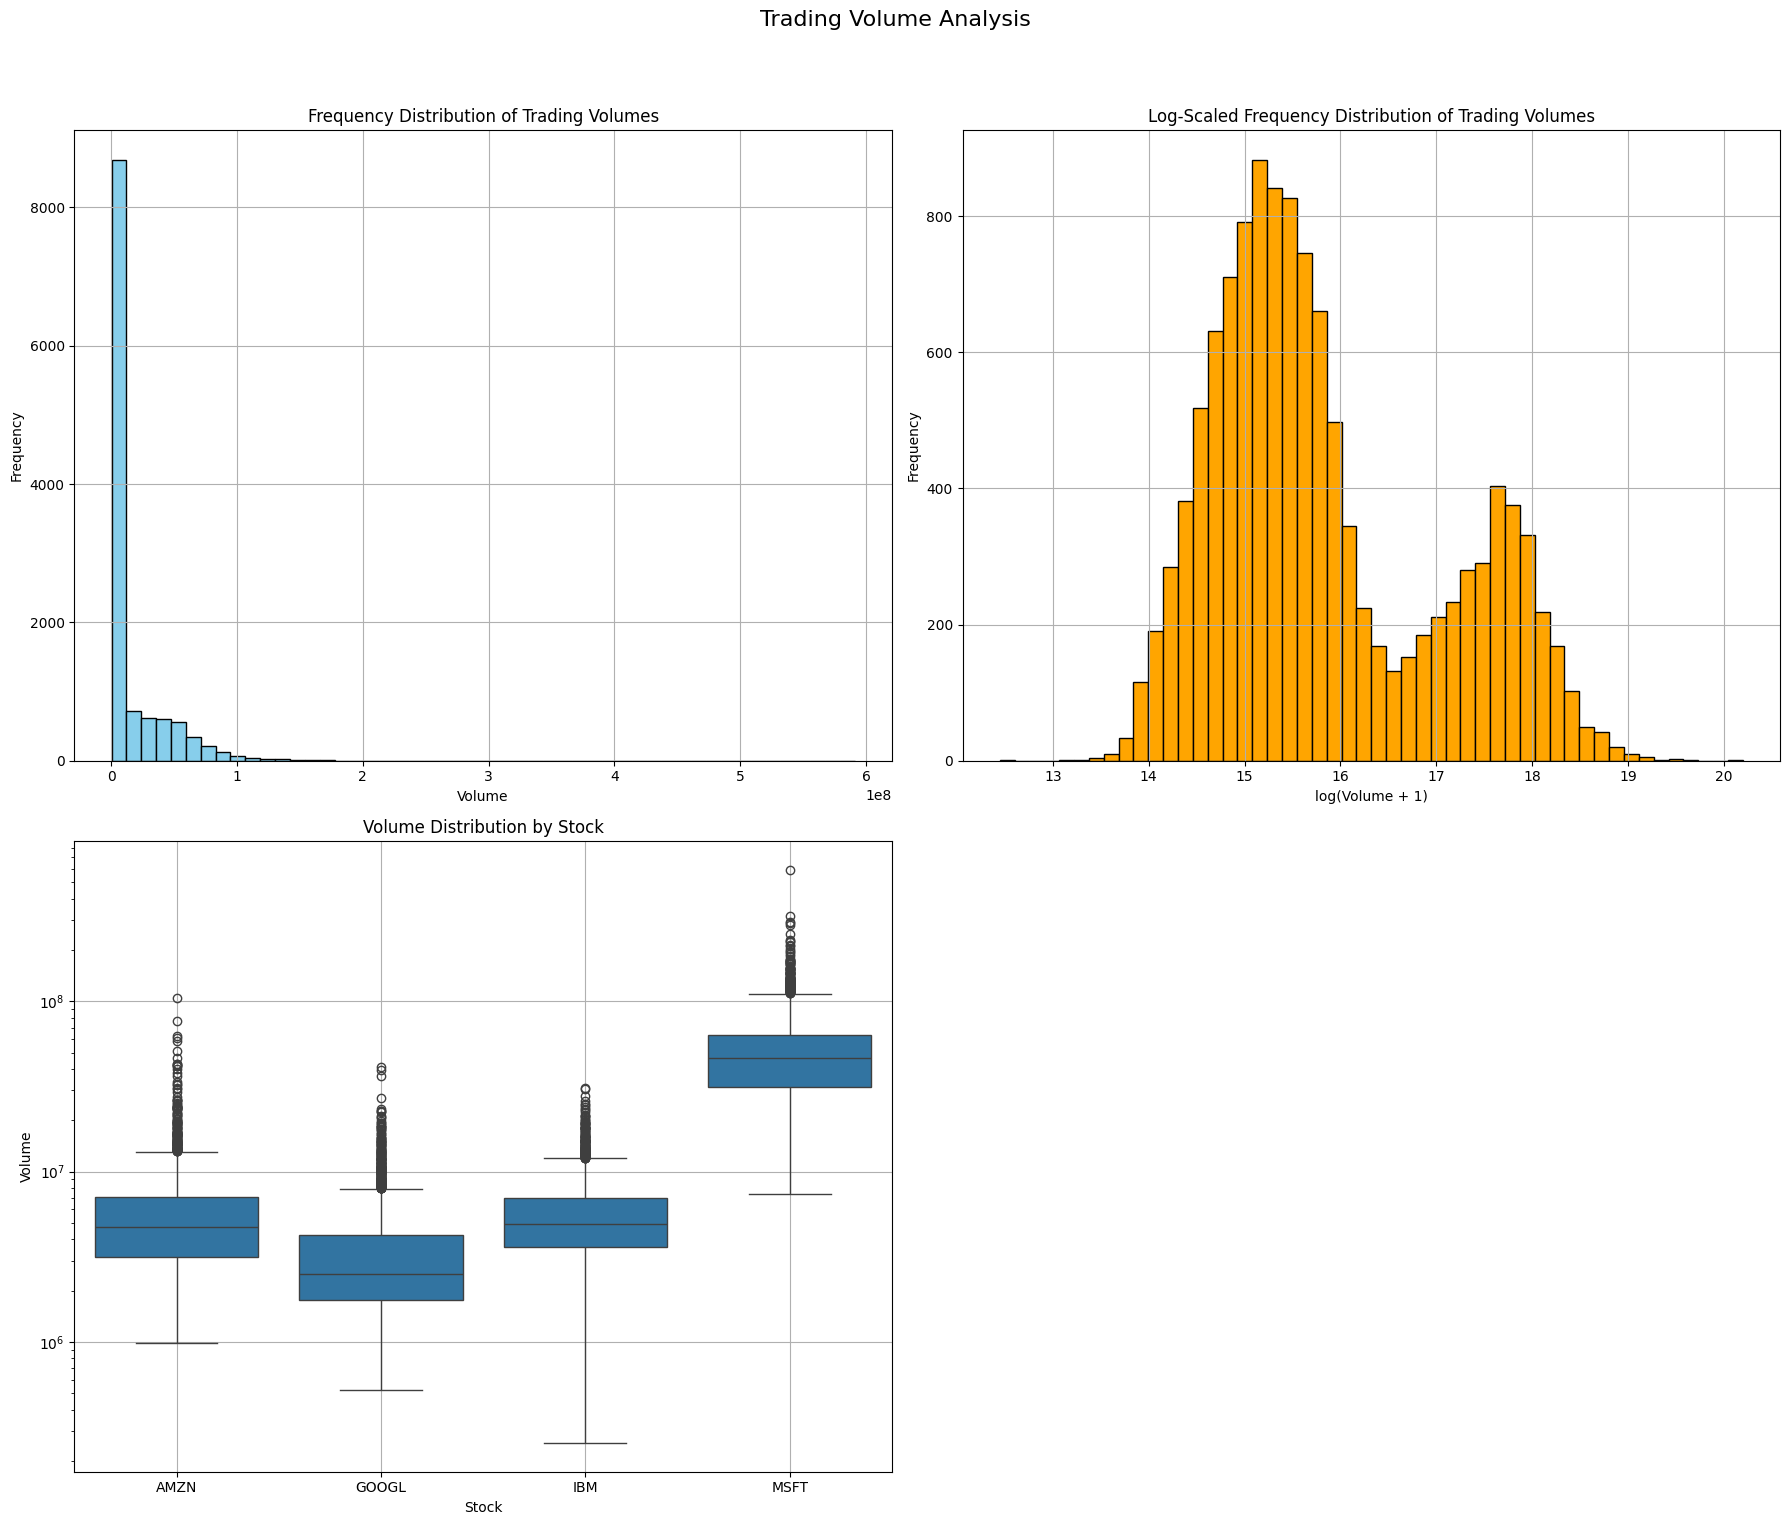

In [14]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('Trading Volume Analysis', fontsize=16)

# Plot 1: Raw volume histogram
axes[0, 0].hist(cleaned_data['Volume'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title("Frequency Distribution of Trading Volumes")
axes[0, 0].set_xlabel("Volume")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].grid(True)

# Plot 2: Log-transformed volume histogram
log_volume = np.log1p(cleaned_data['Volume'].dropna())
axes[0, 1].hist(log_volume, bins=50, color='orange', edgecolor='black')
axes[0, 1].set_title("Log-Scaled Frequency Distribution of Trading Volumes")
axes[0, 1].set_xlabel("log(Volume + 1)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].grid(True)

# Plot 3: Volume by stock as a boxplot (spans both bottom columns)
sns.boxplot(data=cleaned_data, x='Stock', y='Volume', ax=axes[1, 0])
axes[1, 0].set_title("Volume Distribution by Stock")
axes[1, 0].set_xlabel("Stock")
axes[1, 0].set_ylabel("Volume")
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

# Hide the unused bottom-right subplot
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
plt.show()


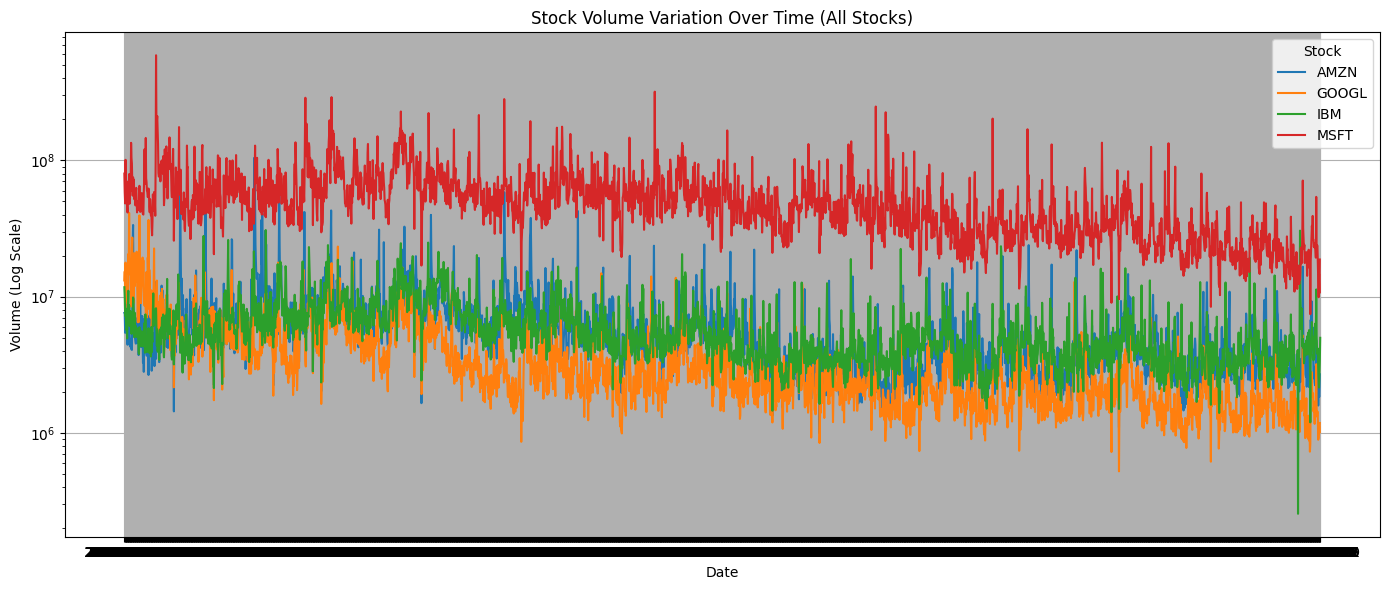

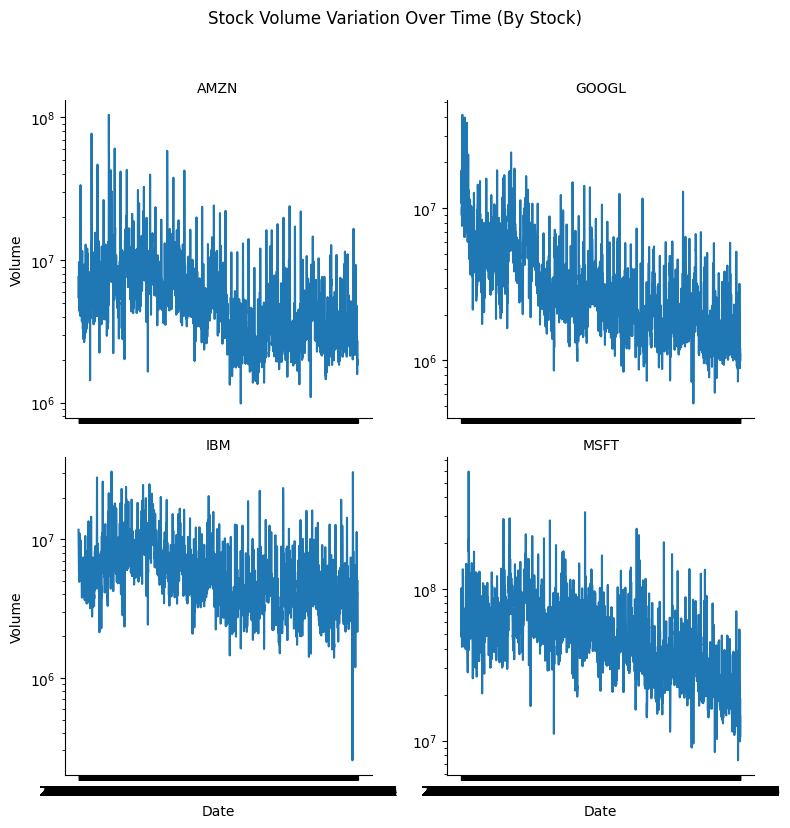

In [12]:
# --- Combined Line Plot for All Stocks ---
plt.figure(figsize=(14, 6))
sns.lineplot(data=cleaned_data, x='Date', y='Volume', hue='Stock')
plt.title('Stock Volume Variation Over Time (All Stocks)')
plt.xlabel('Date')
plt.ylabel('Volume (Log Scale)')
plt.yscale('log')
plt.legend(title='Stock')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Faceted Line Plots for Individual Stocks ---
g = sns.FacetGrid(cleaned_data, col='Stock', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x='Date', y='Volume')
g.set_axis_labels("Date", "Volume")
g.set_titles("{col_name}")
g.fig.suptitle("Stock Volume Variation Over Time (By Stock)", y=1.03)
g.set(yscale='log')  # Optional: Set log scale for each subplot
plt.tight_layout()
plt.show()

#### **1.2.2**
Analyse correlations between features.

Correlation Matrix (Close):
 Stock      AMZN     GOOGL       IBM      MSFT
Stock                                        
AMZN   1.000000  0.972854  0.395349  0.953656
GOOGL  0.972854  1.000000  0.410647  0.968973
IBM    0.395349  0.410647  1.000000  0.289543
MSFT   0.953656  0.968973  0.289543  1.000000


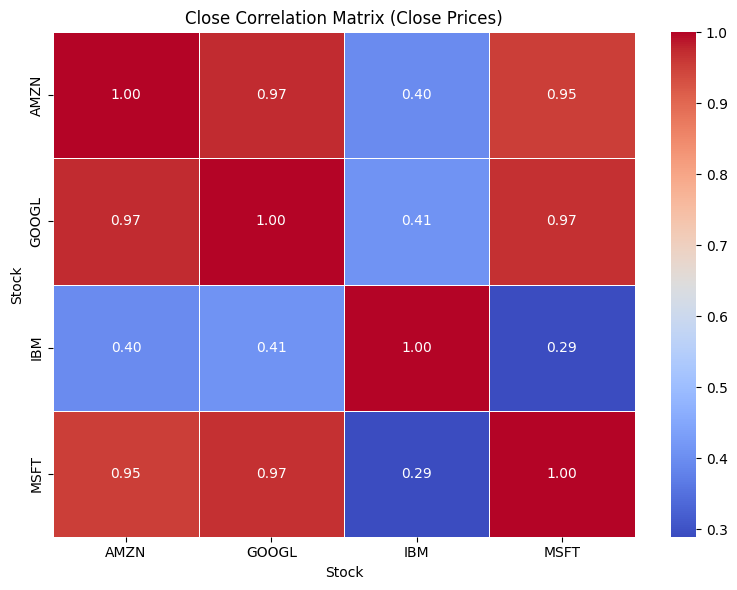

Correlation Matrix (Volume):
 Stock      AMZN     GOOGL       IBM      MSFT
Stock                                        
AMZN   1.000000  0.327162  0.390736  0.384559
GOOGL  0.327162  1.000000  0.445371  0.441106
IBM    0.390736  0.445371  1.000000  0.474786
MSFT   0.384559  0.441106  0.474786  1.000000


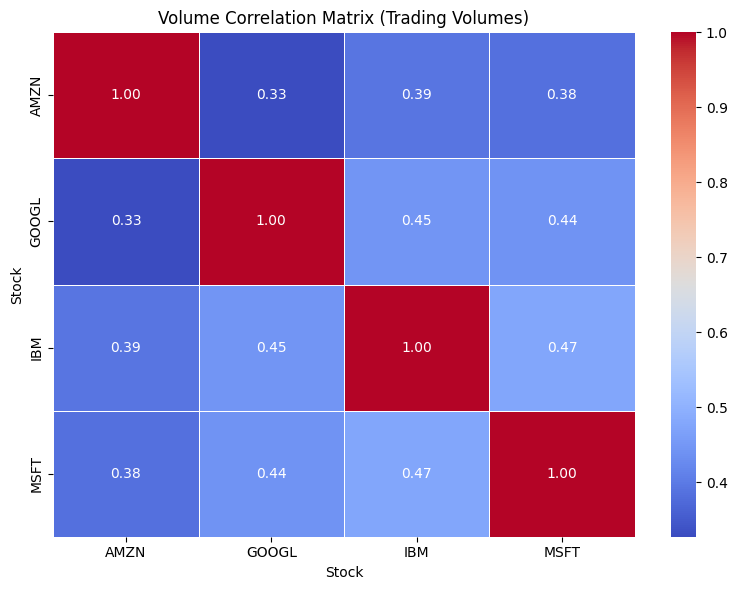

In [13]:
# Lets define a function to validate the correlation between volume and based on close as well.
def compute_and_plot_correlations(df, value_column, title_suffix=""):
    pivot_df = df.pivot(index='Date', columns='Stock', values=value_column)
    corr_matrix = pivot_df.corr()

    print(f"Correlation Matrix ({value_column}):\n", corr_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(f'{value_column} Correlation Matrix {title_suffix}')
    plt.tight_layout()
    plt.show()

    return corr_matrix

# Correlation based on 'Close' prices
price_corr = compute_and_plot_correlations(cleaned_data, 'Close', "(Close Prices)")

# Correlation based on 'Volume'
volume_corr = compute_and_plot_correlations(cleaned_data, 'Volume', "(Trading Volumes)")

### **1.3 Data Processing**

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1**
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.



In [15]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_rnn_windowed_data(df, window_size=3, step_size=1, target_names=None, feature_cols=['Close']):

    X_all = []
    y_all = []

    if target_names is None:
        raise ValueError("Please provide the list of stock names as 'target_names'.")

    for stock in target_names:
        stock_df = df[df['Name'] == stock].sort_values(by='Date').reset_index(drop=True)

        # Only keep necessary features for X and the target ('Close') for y
        features = stock_df[feature_cols].values
        targets = stock_df['Close'].values

        for start in range(0, len(stock_df) - window_size, step_size):
            end = start + window_size
            if end < len(stock_df):
                X_all.append(features[start:end])
                y_all.append(targets[end])  # target is the close price after the window

    X_all = np.array(X_all)
    y_all = np.array(y_all)

    return X_all, y_all


In [16]:
def load_and_merge_stock_data(file_list):
    merged_df = None
    for file in file_list:
        stock_name = file.split('_')[0].upper()
        df = pd.read_csv(file, parse_dates=['Date'])
        df = df[['Date', 'Close']]  # Keep only needed columns
        df.rename(columns={'Close': f'Close{stock_name}'}, inplace=True)

        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on='Date', how='inner')

    return merged_df

In [17]:
file_list = ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'IBM_stocks_data.csv', 'MSFT_stocks_data.csv']
cleaned_target=load_and_merge_stock_data(file_list)
cleaned_target

,Date,CloseAMZN,CloseGOOGL,CloseIBM,CloseMSFT
0,2006-01-03,47.58,217.83,82.06,26.84
1,2006-01-04,47.25,222.84,81.95,26.97
2,2006-01-05,47.65,225.85,82.50,26.99
3,2006-01-06,47.87,233.06,84.95,26.91
4,2006-01-09,47.08,233.68,83.73,26.86
...,...,...,...,...,...
3014,2017-12-22,1168.36,1068.86,152.50,85.51
3015,2017-12-26,1176.76,1065.85,152.83,85.40
3016,2017-12-27,1182.26,1060.20,153.13,85.71
3017,2017-12-28,1186.10,1055.95,154.04,85.72


#### **1.3.2**
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [18]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows
def scale_windows(windowed_X, windowed_y, scaler_type='standard'):


    from sklearn.preprocessing import MinMaxScaler

    if scaler_type == 'standard':
        x_scaler = StandardScaler()
        y_scaler = StandardScaler()
    elif scaler_type == 'minmax':
        x_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
    else:
        raise ValueError("Only 'standard' and 'minmax' scaler types are supported.")

    # First reshape X into 2D for partial fitting
    all_X = np.concatenate(windowed_X, axis=0)
    x_scaler.partial_fit(all_X)

    # Fit y scaler on full y
    windowed_y = np.array(windowed_y).reshape(-1, 1)
    y_scaler.partial_fit(windowed_y)

    # Transform each window individually
    scaled_X = [x_scaler.transform(window) for window in windowed_X]
    scaled_y = y_scaler.transform(windowed_y).flatten()

    return scaled_X, scaled_y, x_scaler, y_scaler

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3**
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [20]:
# Define a function to create input and output data points from the master DataFrame

def prepare_rnn_data(master_df, target_names, window_size=5, window_stride=1, split_ratio=0.8, scaler_type='minmax'):
    """
    Prepares RNN input data by windowing and scaling.
    """
    data = master_df.copy().dropna().reset_index(drop=True)

    # We will Keep original columns for later reference if needed, but process numeric data
    original_columns = data.columns.tolist()

    if 'Date' in data.columns:
        data = data.drop(columns=['Date']) # Drop date before scaling/splitting

    # We are Validating target columns
    missing_targets = [t for t in target_names if t not in data.columns]
    if missing_targets:
        raise ValueError(f"Missing target columns in data: {missing_targets}")

    # Separate potential features and targets
    # Drop target columns to get potential features
    potential_features = data.drop(columns=target_names)
    targets_data = data[target_names]

    # If no other features exist besides targets, use targets as features as well
    if potential_features.empty:
        print("Warning: No independent features found. Using target variables as features.")
        features_data = targets_data # Use targets as features if no other features
    else:
        features_data = potential_features # Use actual features if they exist

    # We are actually passing parameter for scaler but if required we can also use standard scaler hence adding this condition
    if scaler_type == 'minmax':
        feature_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        feature_scaler = StandardScaler() # Added StandardScaler option
        target_scaler = StandardScaler() # Added StandardScaler option
    else:
         raise ValueError("Only 'minmax' and 'standard' scaler types are supported .")


    # Scale features and targets
    # Ensure features_data is not empty before scaling
    if features_data.empty:
        # If features_data is empty, scaled_features will be an empty array.
        # The next step (concatenation) will still work correctly if targets_data is not empty.
        scaled_features = np.array([]).reshape(-1, 0) # Create an empty 2D array
    else:
        scaled_features = feature_scaler.fit_transform(features_data)

    # Scale targets
    scaled_targets = target_scaler.fit_transform(targets_data)

    # Combine scaled features and targets for windowing
    # Ensure both scaled_features and scaled_targets are 2D arrays for concatenation
    if scaled_features.ndim == 1:
         scaled_features = scaled_features.reshape(-1, 1)
    if scaled_targets.ndim == 1:
         scaled_targets = scaled_targets.reshape(-1, 1)

    # Concatenate scaled features and targets. Features come first.
    if scaled_features.shape[1] > 0:
        # If there are actual features, concatenate them with targets
        combined_scaled_data = np.concatenate([scaled_features, scaled_targets], axis=1)
    else:
         # If no independent features, combined data is just the scaled targets
         combined_scaled_data = scaled_targets


    X, y = [], []
    # Ensure we have enough data for at least one window and one target
    if len(combined_scaled_data) >= window_size + 1:
        for i in range(0, len(combined_scaled_data) - window_size, window_stride):
            end = i + window_size
            # X window includes the window_size steps up to 'end'
            X_window = combined_scaled_data[i:end]

            # y target is the value(s) *after* the window, at index 'end'
            # We want to predict the target column(s) only
            # The target columns are the *last* columns in the combined_scaled_data
            y_window = combined_scaled_data[end, -len(target_names):]

            X.append(X_window)
            y.append(y_window)

    X, y = np.array(X), np.array(y)

    # Split into train/test
    split_index = int(len(X) * split_ratio)
    # Ensure split_index is not out of bounds
    if split_index >= len(X):
        split_index = len(X) # Handle cases with very little data

    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]

    # Return scalers to potentially inverse transform predictions later
    return X_train, y_train, X_test, y_test, feature_scaler, target_scaler


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4**
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [22]:
# Checking for patterns in different sequence lengths

cleaned_target['Date'] = pd.to_datetime(cleaned_target['Date'])
cleaned_target1 = cleaned_target.sort_values('Date').reset_index(drop=True)

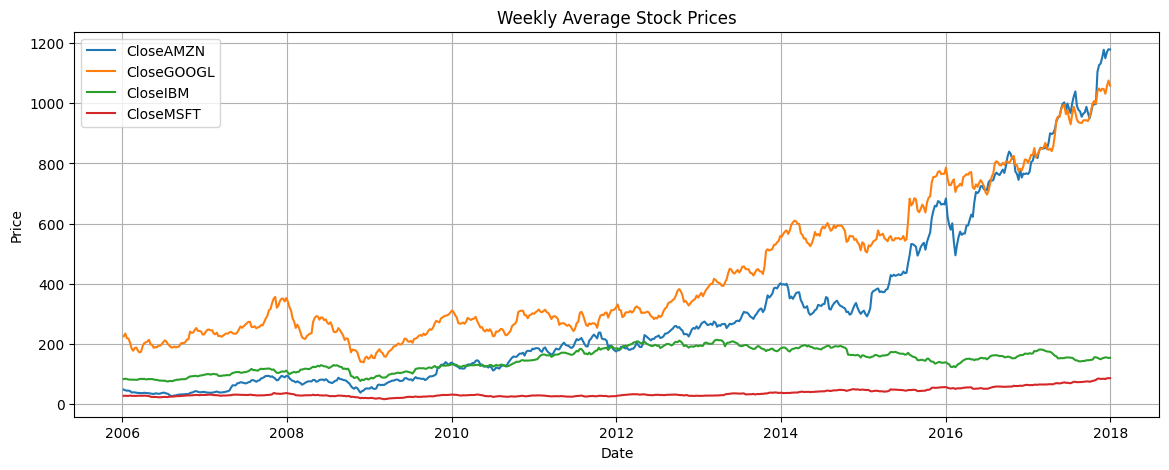

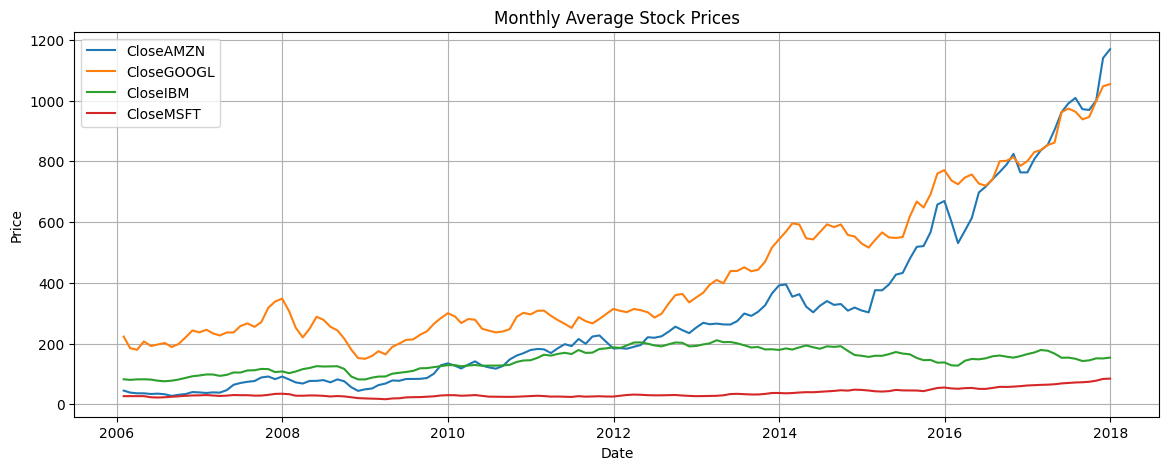

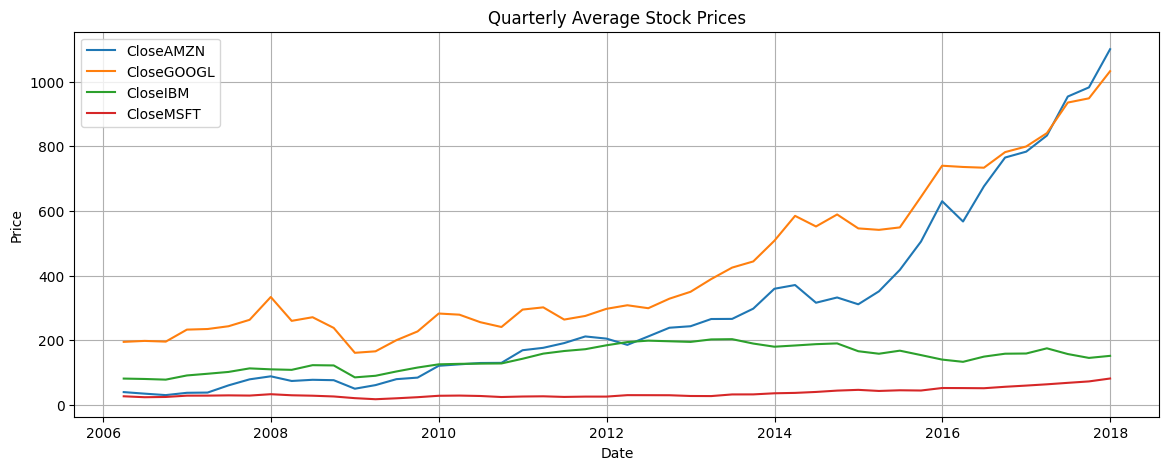

In [23]:
# Assuming 'Date' column exists and is datetime type
df = cleaned_target1.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Aggregation rules
for rule, label in [('W', 'Weekly'), ('M', 'Monthly'), ('Q', 'Quarterly')]:
    plt.figure(figsize=(14, 5))
    for stock in ['CloseAMZN', 'CloseGOOGL', 'CloseIBM', 'CloseMSFT']:
        stock_resampled = df[stock].resample(rule).mean()
        plt.plot(stock_resampled, label=stock)
    plt.title(f'{label} Average Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

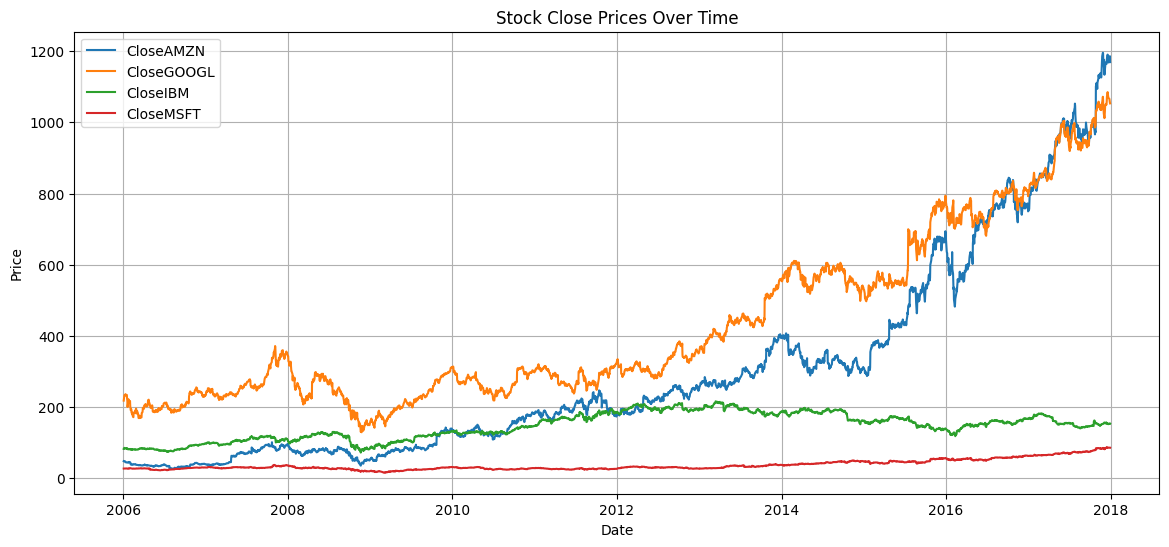

In [65]:
plt.figure(figsize=(14, 6))
for stock in ['CloseAMZN', 'CloseGOOGL', 'CloseIBM', 'CloseMSFT']:
    plt.plot(cleaned_target1['Date'], cleaned_target1[stock], label=stock)

plt.title("Stock Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

#### **1.3.5**
Call the functions to create testing and training instances of predictor and target features.

In [24]:
# Create data instances from the master data frame using decided window size and window stride
# Define the target stock columns
target_stocks = ['CloseAMZN', 'CloseGOOGL', 'CloseIBM', 'CloseMSFT']

# Decide on window size and stride based on analysis (e.g., 20 = 4 weeks of data)
window_size = 20
window_stride = 1
split_ratio = 0.8

# Call the data preparation function
X_train, y_train, X_test, y_test, feature_scaler, target_scaler = prepare_rnn_data(
    master_df=cleaned_target1,       # your full cleaned DataFrame
    target_names=target_stocks,
    window_size=window_size,
    window_stride=window_stride,
    split_ratio=split_ratio,
    scaler_type='minmax'             # you can also use 'standard'
)




In [28]:
# Check the number of training and testing samples
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

# Optionally, check their shapes for clarity
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

Number of training samples: 2399
Number of testing samples: 600
X_train shape: (2399, 20, 8)
y_train shape: (2399, 4)
X_test shape:  (600, 20, 8)
y_test shape:  (600, 4)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [29]:
# Check if the datasets are compatible inputs to neural networks

print("Any NaNs in X_train:", np.isnan(X_train).any())
print("Any NaNs in y_train:", np.isnan(y_train).any())
print("Any Infs in X_train:", np.isinf(X_train).any())
print("Any Infs in y_train:", np.isinf(y_train).any())
print("NaNs in X_test:", np.isnan(X_test).any())
print("NaNs in y_test:", np.isnan(y_test).any())


Any NaNs in X_train: False
Any NaNs in y_train: False
Any Infs in X_train: False
Any Infs in y_train: False
NaNs in X_test: False
NaNs in y_test: False


## **2 RNN Models**
In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model**

#### **2.1.1**
Create a function that builds a simple RNN model based on the layer configuration provided.

In [32]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def create_simple_rnn(input_shape, output_units, rnn_units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=1):

    model = Sequential()

    for i in range(num_layers):
        return_sequences = i < num_layers - 1  # Only return sequences if another layer follows
        model.add(SimpleRNN(units=rnn_units,
                            return_sequences=return_sequences,
                            input_shape=input_shape if i == 0 else None))
        model.add(Dropout(dropout_rate))

    model.add(Dense(output_units))  # Output layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

2.1.2

Perform hyperparameter tuning to find the optimal network configuration.

In [33]:
def train_rnn_with_hyperparams(X_train, y_train, X_val, y_val, params_grid):
    """
    Trains RNNs using different hyperparameters and returns the best model.

    params_grid: List of dictionaries with hyperparameter combinations
    """
    best_model = None
    best_val_mae = float('inf')
    best_params = None

    for params in params_grid:
        print(f"Training with params: {params}")
        model = build_rnn_model(
            input_shape=X_train.shape[1:],
            output_size=y_train.shape[1],
            rnn_units=params['rnn_units'],
            dropout_rate=params['dropout'],
            learning_rate=params['lr']
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=params.get('epochs', 20),
            batch_size=params.get('batch_size', 32),
            verbose=0
        )

        val_mae = min(history.history['val_mae'])
        print(f"Validation MAE: {val_mae:.4f}")

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_model = model
            best_params = params

    print("\nBest Hyperparameters:", best_params)
    return best_model


In [34]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the trained model on test data.
    """
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test MAE: {mae:.4f}")
    return mae

In [35]:
param_grid = [
    {'rnn_units': 32, 'dropout': 0.1, 'lr': 0.001, 'epochs': 30, 'batch_size': 32},
    {'rnn_units': 64, 'dropout': 0.2, 'lr': 0.001, 'epochs': 30, 'batch_size': 32},
    {'rnn_units': 128, 'dropout': 0.3, 'lr': 0.0005, 'epochs': 30, 'batch_size': 64}
]

# Split some of the training data into validation set
val_split = int(0.8 * len(X_train))
X_val, y_val = X_train[val_split:], y_train[val_split:]
X_train_new, y_train_new = X_train[:val_split], y_train[:val_split]

best_rnn_model = train_rnn_with_hyperparams(X_train_new, y_train_new, X_val, y_val, param_grid)

# Final evaluation
evaluate_model(best_rnn_model, X_test, y_test)

Training with params: {'rnn_units': 32, 'dropout': 0.1, 'lr': 0.001, 'epochs': 30, 'batch_size': 32}
Validation MAE: 0.0210
Training with params: {'rnn_units': 64, 'dropout': 0.2, 'lr': 0.001, 'epochs': 30, 'batch_size': 32}
Validation MAE: 0.0156
Training with params: {'rnn_units': 128, 'dropout': 0.3, 'lr': 0.0005, 'epochs': 30, 'batch_size': 64}
Validation MAE: 0.0160

Best Hyperparameters: {'rnn_units': 64, 'dropout': 0.2, 'lr': 0.001, 'epochs': 30, 'batch_size': 32}
Test MAE: 0.0822


0.08217635005712509

#### **2.1.3**
Run for optimal Simple RNN Model and show final results.

In [36]:
#Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# Split data into training and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Optimal hyperparameters (can be tuned further)
input_shape = X_train.shape[1:]  # (time_steps, features)
rnn_units = 64
num_layers = 2
dropout_rate = 0.2
activation = 'tanh'
learning_rate = 0.001
epochs = 50
batch_size = 32

# Define the number of output units based on the number of target stocks
num_output_units = len(target_stocks)


# Build RNN model
model = Sequential()
for i in range(num_layers):
    return_seq = (i < num_layers - 1)
    model.add(SimpleRNN(units=rnn_units,
                        activation=activation,
                        return_sequences=return_seq,
                        input_shape=input_shape if i == 0 else None))
    model.add(Dropout(dropout_rate))
model.add(Dense(units=num_output_units))  # Multiple outputs

# Compile model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

# Train model
history = model.fit(X_tr, y_tr,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

# Final evaluation
loss, mae = model.evaluate(X_val, y_val, verbose=0)
print(f"\nFinal validation MAE: {mae:.4f}")


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1780 - mae: 0.3194 - val_loss: 0.0040 - val_mae: 0.0486
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0338 - mae: 0.1411 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0192 - mae: 0.1053 - val_loss: 0.0042 - val_mae: 0.0453
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0134 - mae: 0.0890 - val_loss: 7.7101e-04 - val_mae: 0.0209
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0095 - mae: 0.0729 - val_loss: 7.2375e-04 - val_mae: 0.0212
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0083 - mae: 0.0685 - val_loss: 5.1510e-04 - val_mae: 0.0180
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0069 - mae: 0.0619 - val_loss: 4.9824e-04 - val_mae: 0.0175
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0059 - mae: 0.0573 - val_loss: 5.1153e-04 - val_mae: 0.0174
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13m

Plotting the actual vs predicted values

In [37]:
def plot_all_predictions(y_test, y_pred_scaled, target_scaler, target_stocks):
    """
    Plot actual vs predicted prices for multiple stocks.

    Parameters:
    - y_test: Scaled ground truth test target values (2D array)
    - y_pred_scaled: Scaled model predictions (2D array)
    - target_scaler: Fitted MinMaxScaler used on target values
    - target_stocks: List of target stock column names (e.g. ['CloseAMZN', 'CloseGOOGL'])
    """
    num_stocks = len(target_stocks)
    fig, axs = plt.subplots(nrows=num_stocks, figsize=(14, 4 * num_stocks))

    if num_stocks == 1:
        axs = [axs]  # Ensure iterable if only one plot

    for i, stock in enumerate(target_stocks):
        # Prepare padded arrays to inverse transform
        y_pred_padded = np.zeros((y_pred_scaled.shape[0], num_stocks))
        y_pred_padded[:, i] = y_pred_scaled[:, i]
        y_pred_unscaled = target_scaler.inverse_transform(y_pred_padded)[:, i]

        y_test_padded = np.zeros((y_test.shape[0], num_stocks))
        y_test_padded[:, i] = y_test[:, i]
        y_test_unscaled = target_scaler.inverse_transform(y_test_padded)[:, i]

        axs[i].plot(y_test_unscaled, label='Actual', color='blue')
        axs[i].plot(y_pred_unscaled, label='Predicted', color='red', linestyle='--')
        axs[i].set_title(f'Actual vs Predicted Prices - {stock}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Price')
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


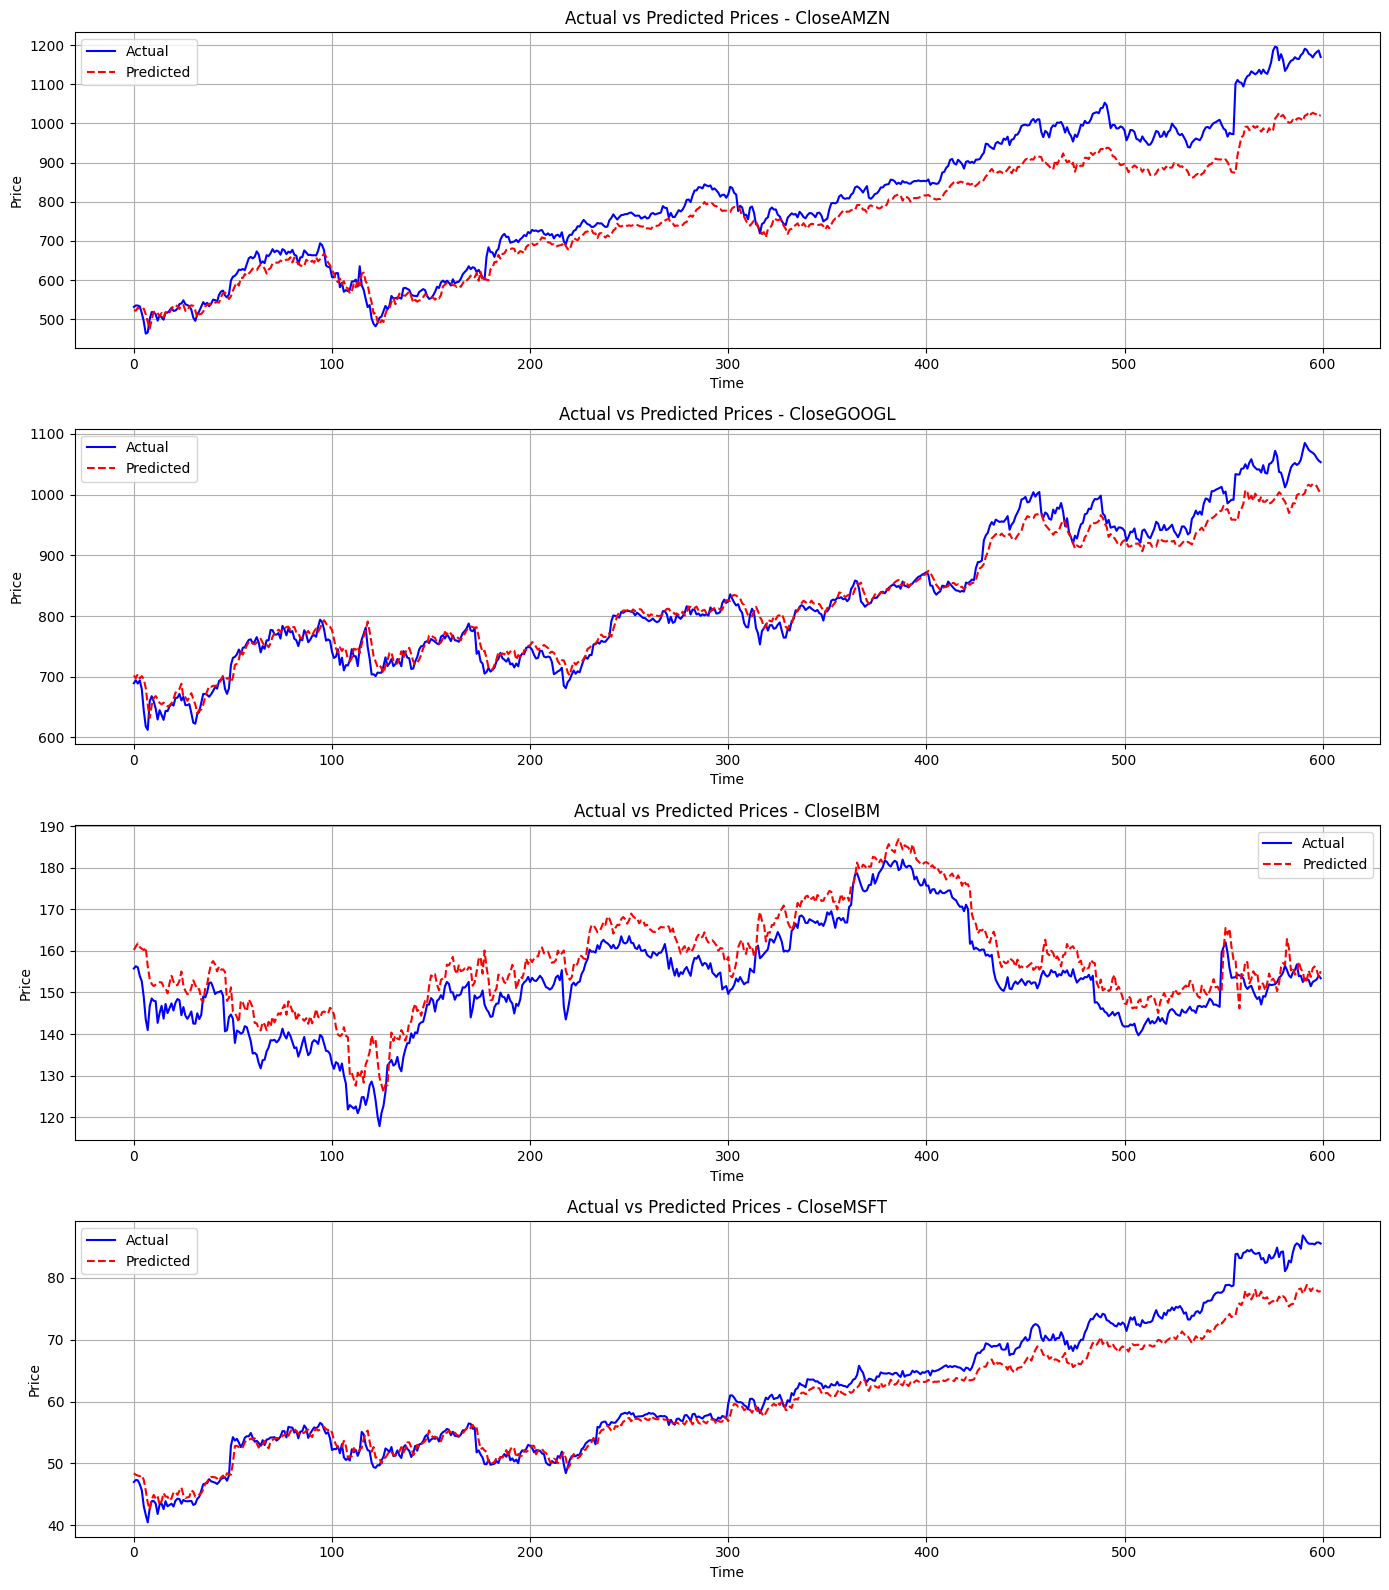

In [38]:
y_pred_scaled = model.predict(X_test)
plot_all_predictions(y_test, y_pred_scaled, target_scaler, target_stocks)

In [39]:
# Compute the performance of the model on the testing data set
# Predict
y_pred = model.predict(X_test).flatten()
y_true = y_test.flatten()

# Remove any NaNs
mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
y_true_clean = y_true[mask]
y_pred_clean = y_pred[mask]

# Compute metrics
mae = mean_absolute_error(y_true_clean, y_pred_clean)
mse = mean_squared_error(y_true_clean, y_pred_clean)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_clean, y_pred_clean)

# Print results
print(f"Model Performance on Test Data:")
print(f"  MAE  = {mae:.4f}")
print(f"  MSE  = {mse:.4f}")
print(f"  RMSE = {rmse:.4f}")
print(f"  R²   = {r2:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model Performance on Test Data:
  MAE  = 0.0319
  MSE  = 0.0018
  RMSE = 0.0420
  R²   = 0.9143


### **2.2 Advanced RNN Models**

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1**
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [45]:
#Define a function to create a model and specify default values for hyperparameters

def create_lstm_model(input_shape, lstm_units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=lstm_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4))  # Adjust based on number of target stocks
    model.compile(optimizer='adam', loss='mse')
    return model

# Parameter grid for tuning
param_grid = {
    'lstm_units': [32, 64],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32],
    'epochs': [20]
}

# Grid search
best_model = None
best_score = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    model = create_lstm_model(input_shape=(X_tr.shape[1], X_tr.shape[2]),
                              lstm_units=params['lstm_units'],
                              dropout_rate=params['dropout_rate'])
    model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'],
              verbose=0, validation_split=0.1)
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    if score < best_score:
        best_score = score
        best_model = model
        best_params = params

print("Best MSE:", best_score)
print("Best Parameters:", best_params)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Best MSE: 0.006308565415667612
Best Parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'lstm_units': 64}


#### **2.2.2**
Perform hyperparameter tuning to find the optimal network configuration.

In [49]:
def build_advanced_rnn_model(input_shape,
                              rnn_type='LSTM',          # 'LSTM' or 'GRU'
                              units=64,
                              num_layers=1,
                              dropout=0.2,
                              dense_units=32,
                              learning_rate=0.001):

    model = Sequential()

    RNNLayer = LSTM if rnn_type == 'LSTM' else GRU

    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # only last RNN layer returns False
        if i == 0:
            model.add(RNNLayer(units, return_sequences=return_sequences,
                               input_shape=input_shape))
        else:
            model.add(RNNLayer(units, return_sequences=return_sequences))
        model.add(Dropout(dropout))

    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(input_shape[-1], activation='linear'))  # output matches number of targets

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [50]:
input_shape = X_tr.shape[1:]

model = build_advanced_rnn_model(input_shape,
                                  rnn_type='LSTM',
                                  units=64,
                                  num_layers=2,
                                  dropout=0.3,
                                  dense_units=32,
                                  learning_rate=0.001)

model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 20, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,056 (211.16 KB)

 Trainable params: 54,056 (211.16 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:

class RNNHyperModel(HyperModel):
    def __init__(self, input_shape, output_dim, rnn_type='LSTM'):
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.rnn_type = rnn_type

    def build(self, hp):
        model = Sequential()
        RNN = LSTM if self.rnn_type == 'LSTM' else GRU

        # Choose number of layers
        for i in range(hp.Int('num_layers', 1, 3)):
            return_sequences = i < hp.Int('num_layers', 1, 3) - 1
            if i == 0:
                model.add(RNN(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
                              return_sequences=return_sequences,
                              input_shape=self.input_shape))
            else:
                model.add(RNN(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
                              return_sequences=return_sequences))
            model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

        model.add(Dense(self.output_dim))

        model.compile(
            optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
            loss='mse',
            metrics=['mae']
        )
        return model

In [52]:
# Running the Random search Turner:

input_shape = X_train.shape[1:]
output_dim = y_train.shape[1]

tuner = RandomSearch(
    RNNHyperModel(input_shape, output_dim, rnn_type='LSTM'),
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='rnn_tuning',
    project_name='stock_rnn'
)

In [53]:
tuner.search(X_train, y_train,
             epochs=15,
             batch_size=32,
             validation_split=0.2)

Trial 10 Complete [00h 01m 07s]
val_mae: 0.0322689488530159

Best val_mae So Far: 0.014822897501289845
Total elapsed time: 00h 06m 07s


#### **2.2.3**
Run for optimal RNN Model and show final results.

In [54]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model


def build_optimal_rnn(input_shape, output_dim):
    model = Sequential([
        LSTM(units=64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(units=32),
        Dropout(0.2),
        Dense(units=output_dim)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def train_and_evaluate_model(X_train, y_train, X_test, y_test, target_names):
    input_shape = X_train.shape[1:]
    output_dim = y_train.shape[1]

    model = build_optimal_rnn(input_shape, output_dim)

    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Final Test MAE: {mae:.4f}")
    print(f"Final Test MSE: {mse:.4f}")

    # Plot predictions for each target
    for i, name in enumerate(target_names):
        plt.figure(figsize=(10, 4))
        plt.plot(y_test[:, i], label=f'Actual {name}', color='blue')
        plt.plot(y_pred[:, i], label=f'Predicted {name}', color='orange')
        plt.title(f'Actual vs Predicted - {name}')
        plt.xlabel('Time Step')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return model, history, y_pred

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0349 - mae: 0.1141 - val_loss: 0.0132 - val_mae: 0.1010
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0044 - mae: 0.0470 - val_loss: 0.0061 - val_mae: 0.0644
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0031 - mae: 0.0392 - val_loss: 0.0037 - val_mae: 0.0470
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0027 - mae: 0.0363 - val_loss: 0.0023 - val_mae: 0.0354
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0025 - mae: 0.0348 - val_loss: 0.0026 - val_mae: 0.0387
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0024 - mae: 0.0330 - val_loss: 0.0023 - val_mae: 0.0372
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0022 - mae: 0.0312 - val_loss: 0.0030 - val_mae: 0.0447
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021 - mae: 0.0311 - val_loss: 0.0030 - val_mae: 0.0440
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.001

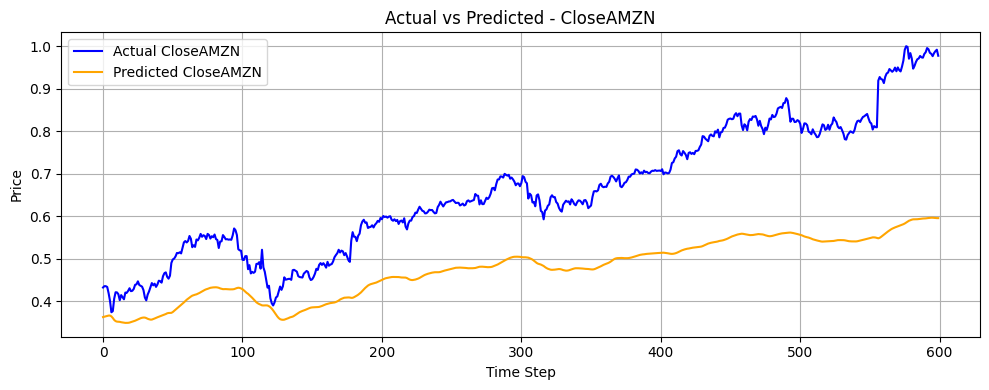

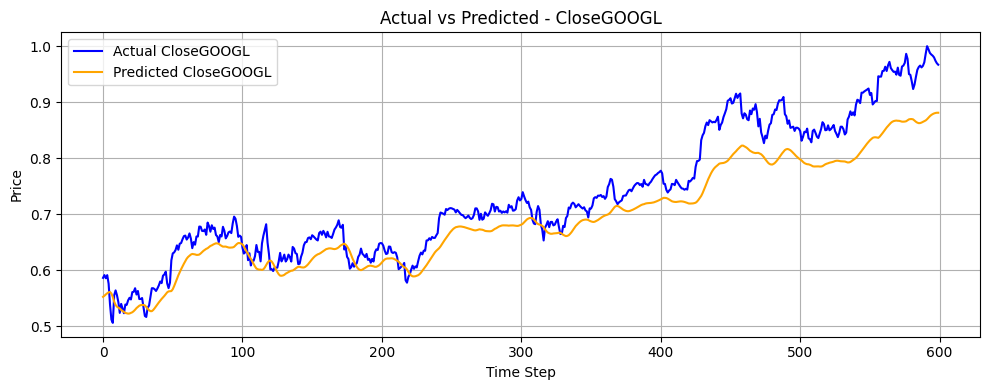

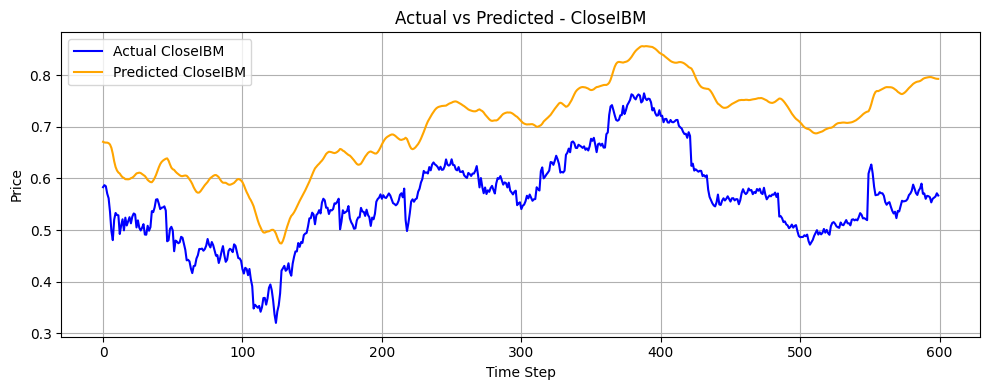

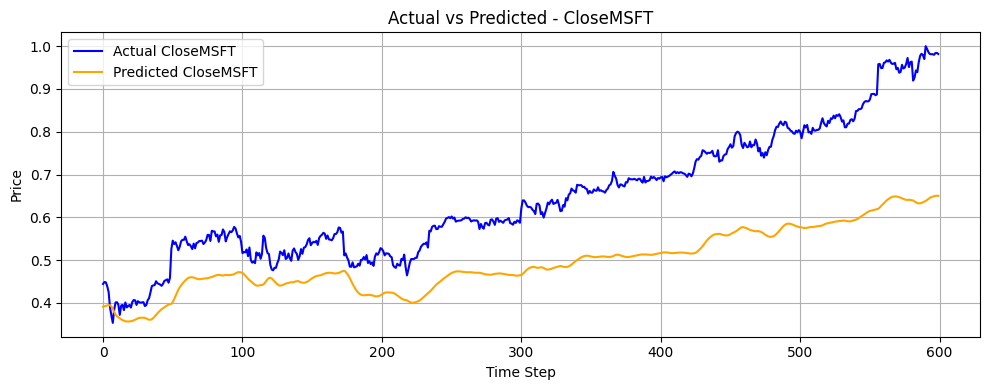

In [56]:
model, history, y_pred = train_and_evaluate_model(X_train, y_train, X_test, y_test, target_stocks)

In [58]:
# Compute the performance of the model on the testing data set
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [59]:

def evaluate_model_performance(y_test, y_pred, target_names):
    for i, name in enumerate(target_names):
        mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        print(f"Performance for {name}:")
        print(f"  MAE:  {mae:.4f}")
        print(f"  MSE:  {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print("-" * 30)

In [60]:
target_names = ['CloseAMZN', 'CloseGOOGL', 'CloseIBM', 'CloseMSFT']  # adjust based on your actual targets
evaluate_model_performance(y_true, y_pred, target_names)

Performance for CloseAMZN:
  MAE:  212.5496
  MSE:  55565.5508
  RMSE: 235.7235
------------------------------
Performance for CloseGOOGL:
  MAE:  40.8725
  MSE:  2416.5309
  RMSE: 49.1582
------------------------------
Performance for CloseIBM:
  MAE:  20.2221
  MSE:  451.9240
  RMSE: 21.2585
------------------------------
Performance for CloseMSFT:
  MAE:  10.6944
  MSE:  146.2036
  RMSE: 12.0915
------------------------------


In [61]:
def plot_all_predictions(y_true, y_pred, target_names, num_days=100):
    """
    Plot actual vs predicted values for all target stocks.
    """
    plt.figure(figsize=(16, 10))

    for i, name in enumerate(target_names):
        plt.subplot(len(target_names), 1, i + 1)
        plt.plot(y_true[:num_days, i], label='Actual', linewidth=2)
        plt.plot(y_pred[:num_days, i], label='Predicted', linestyle='--')
        plt.title(f'{name} - Actual vs Predicted')
        plt.xlabel('Time Step')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

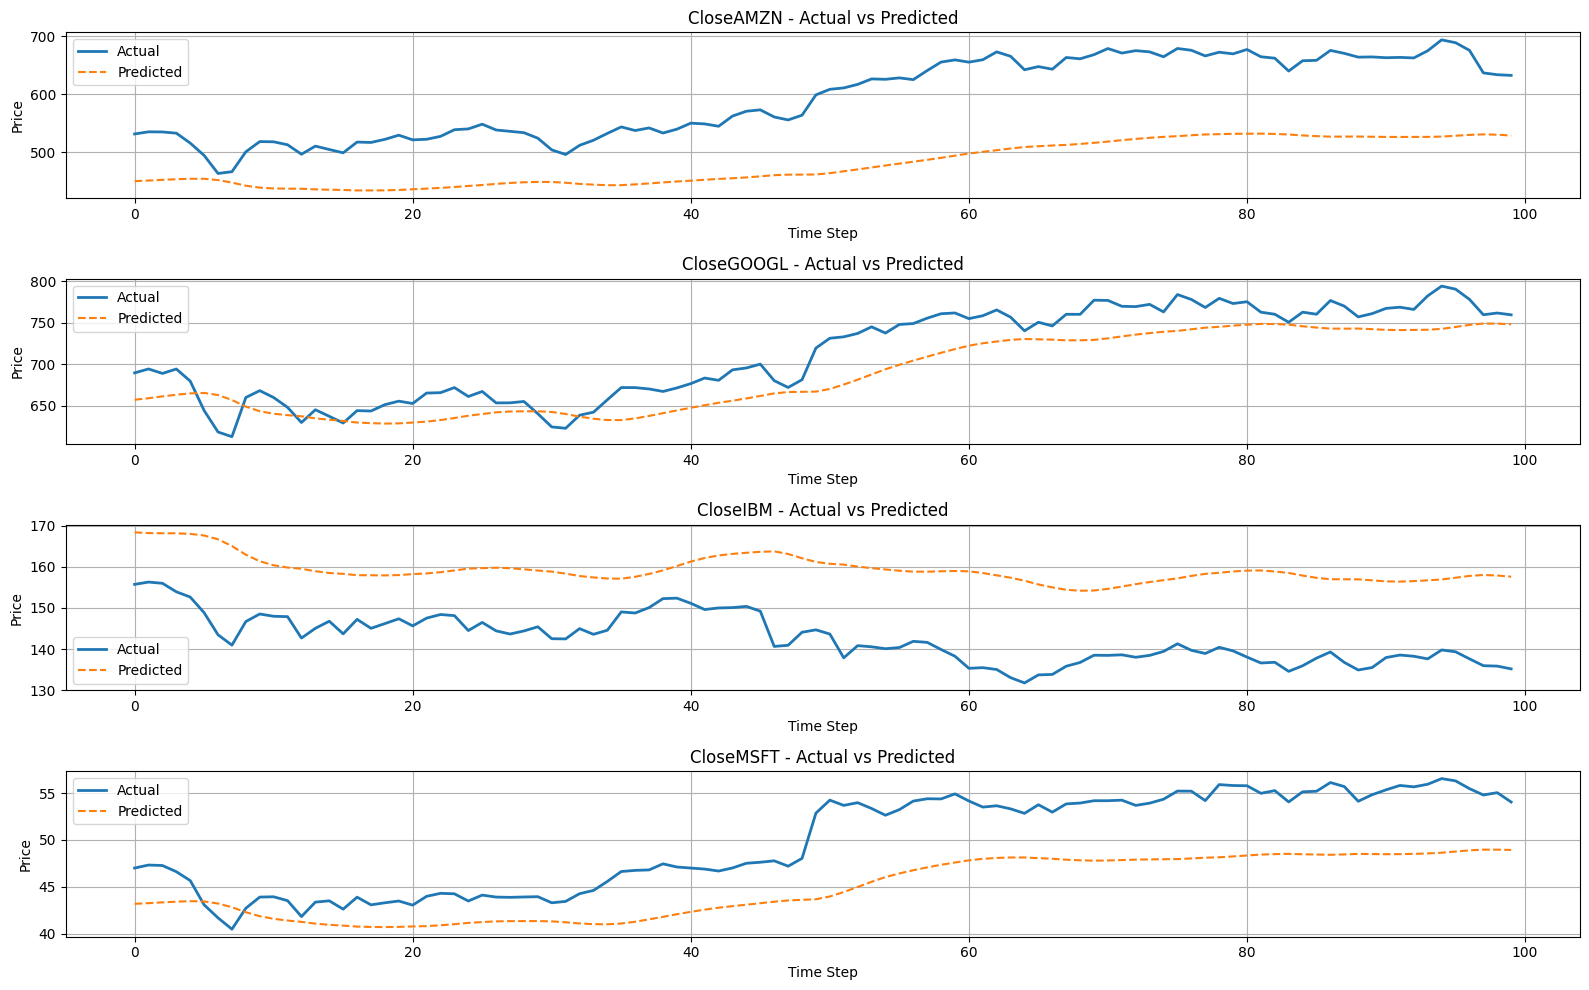

In [62]:
plot_all_predictions(y_true, y_pred, target_names)

Plotting the actual vs predicted values

## **3 Conclusion**

### **3.1 Conclusion and insights**

#### **3.1.1**
Conclude with the insights drawn and final outcomes and results.